In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# matplotlib.rcParams
import datetime as dt
import time
import scipy.stats as stats
from itertools import combinations
import folium
from folium.plugins import FastMarkerCluster
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [325]:
def unpack(row):
    txt = row['location'].replace('(','').replace(')','').split(', ')
    try:
        return {'lat': float(txt[0]), 'long': float(txt[1])}
    except:
        return np.nan
    
def clean_time(row):
    if row[-1] not in ['A','P']:
        return pd.to_datetime(row, format='%H%M').hour
    
    elif row[:2] == '00':
        row = '12' + row[2:]
    row += 'M'
    return pd.to_datetime(row, format='%I%M%p').hour

def get_desc(row):
    code_desc = {21:'No Parking-Street Cleaning',
                 38:'Fail To Display Muni Meter Recpt',
                 14:'No Standing-Day/Time Limits',
                 20:'No Parking-Day/Time Limits',
                 46:'Double Parking'
                }
    return code_desc[row]

def get_grouped_counts(df, variable_lst):
    return df.groupby(variable_lst)[['Summons Number']].count().reset_index()

def empirical_distribution(x, data):
    weight = 1.0 / len(data)
    count = np.zeros(shape=len(x))
    for datum in data:
        count = count + np.array(x >= datum)
    return weight * count

def grp_count_p_values (df, category):
    '''
    parameters:
    df = dataframe with day of week

    returns:
    result_df = new dataframe with p_values and
    difference in means
    '''
    result_df = pd.DataFrame()
    groups = df[category].unique()
    
    for a,b in combinations(groups, 2):
        if a == b:
            continue
        else:
            a_df = df[df[category]==a].copy()
            b_df = df[df[category]==b].copy()
            a_mean = a_df['Summons Number'].mean()
            b_mean = b_df['Summons Number'].mean()
            mean_diff = abs(a_mean - b_mean)
            pvalue = stats.mannwhitneyu(a_df['Summons Number'], b_df['Summons Number'], alternative='two-sided')[1]
            new_row = {'Group A':a, 
                       'Group B':b,
                       'P-Value':pvalue, 
                       'Mean Difference':mean_diff,
                       'Group A Mean':a_mean,
                       'Group B Mean':b_mean
                      }
            result_df = result_df.append(new_row, ignore_index=True)
    return result_df.sort_values(by=['P-Value'], ascending = True)

In [173]:
park = pd.read_csv('../data/parking_sample.csv', index_col=0)
addr = pd.read_csv('../data/address3.csv', index_col=0)

In [174]:
addr = pd.concat([addr, addr.apply(unpack, axis=1, result_type='expand')], axis=1)
addr.drop(columns=['location'],inplace=True)

In [175]:
park['violation_hour'] = park['Violation Time'].apply(clean_time)
# park['new_time'] = park['new_time'].apply(lambda x: x.strftime('%H:%M'))
park['new_date'] = pd.to_datetime(park['Issue Date'])
park['month'] = park['new_date'].dt.month
park['day'] = park['new_date'].dt.day
park['day_of_week'] = park['new_date'].dt.weekday

park.head()

Summons Number Plate ID Registration State Plate Type  Issue Date  \
0      1440986605   CJBM76                 FL        PAS  07/03/2018   
1      1442478639  HVY3873                 NY        PAS  07/11/2018   
2      8599896052   XDDD96                 NJ        PAS  07/26/2018   
3      8619387285  71288MD                 NY        COM  07/10/2018   
4      8520533279  AF13961                 PA        PAS  07/10/2018   

   Violation Code Vehicle Body Type Vehicle Make Issuing Agency  Street Code1  \
0              21              SUBN        VOLKS              S         48430   
1              21              SUBN        HONDA              S         31790   
2              14              SUBN        CHRYS              T         21730   
3              14              DELV        INTER              T         34090   
4              46              TRAC         MACK              T         24890   

   Street Code2  Street Code3  Vehicle Expiration Date  Violation Location  \
0         42730         13430                        0                  75   
1         35290         65140                 20191002                 100   
2         30790         29290                 88880088                   1   
3         10810         10910                 20180831                  10   
4         18750         18770                 20180088                  19   

   Violation Precinct  Issuer Precinct  Issuer Code Issuer Command  \
0                  75                0       669512           KN05   
1                 100                0       596638           KN16   
2                   1                1       367978           T101   
3                  10               10       365934           T102   
4                  19               19       367885           T103   

  Issuer Squad Violation Time Violation County House Number     Street Name  \
0         0000          0952A                K          309  HEMLOCK STREET   
1         0000          1142A                Q          420   BEACH 65TH ST   
2            G          1040A               NY          100       Greene St   
3            I          1240P               NY          345       W 16th St   
4            N          0119P               NY         1332   Lexington Ave   

   Date First Observed  Law Section Sub Division Days Parking In Effect  \
0                    0          408           D1                BYBBYBB   
1                    0          408           D1                BBYBBBB   
2                    0          408            D                YYYYYYY   
3                    0          408           H0                YYYYYYY   
4                    0          408           F1                YYYYYYY   

  Vehicle Color  Vehicle Year  Feet From Curb                 Address  \
0           BLK             0               0  309 HEMLOCK STREET NYC   
1         WHITE          2017               0   420 BEACH 65TH ST NYC   
2         BLACK             0               0       100 Greene St NYC   
3            MR          2014               0       345 W 16th St NYC   
4         ORANG             0               0  1332 Lexington Ave NYC   

   violation_hour   new_date  month  day  day_of_week  
0               9 2018-07-03      7    3            1  
1              11 2018-07-11      7   11            2  
2              10 2018-07-26      7   26            3  
3              12 2018-07-10      7   10            1  
4              13 2018-07-10      7   10            1

In [153]:
park[['violation_hour','Violation Time']]

violation_hour Violation Time
0                   9          0952A
1                  11          1142A
2                  10          1040A
3                  12          1240P
4                  13          0119P
...               ...            ...
51814               7          0751A
51815              13          0111P
51816              14          0243P
51817               5          0554A
51818              16          0416P

[51819 rows x 2 columns]

In [119]:
time_grp = park.groupby(['violation_hour','Violation Code'])[['Summons Number']].count().reset_index()
time_grp



violation_hour  Violation Code  Summons Number
0                 0              14              58
1                 0              20              58
2                 0              21             251
3                 0              46              22
4                 1              14              63
..              ...             ...             ...
103              23              14              98
104              23              20              62
105              23              21               1
106              23              38               6
107              23              46              28

[108 rows x 3 columns]

In [257]:
park_addr = park.merge(addr, how='left', on='Address')
park_addr['Violation Desc'] = park_addr['Violation Code'].apply(get_desc)
violation21 = park_addr[park_addr['Violation Code'] == 21]
violation38 = park_addr[park_addr['Violation Code'] == 38]
violation14 = park_addr[park_addr['Violation Code'] == 14]
violation20 = park_addr[park_addr['Violation Code'] == 20]
violation46 = park_addr[park_addr['Violation Code'] == 46]

mon = park_addr[park_addr['day_of_week'] == 0]
tues = park_addr[park_addr['day_of_week'] == 1]
wed = park_addr[park_addr['day_of_week'] == 2]
thurs = park_addr[park_addr['day_of_week'] == 3]
fri = park_addr[park_addr['day_of_week'] == 4]
sat = park_addr[park_addr['day_of_week'] == 5]
sun = park_addr[park_addr['day_of_week'] == 6]

In [155]:
park_addr.head()

Summons Number Plate ID Registration State Plate Type  Issue Date  \
0      1440986605   CJBM76                 FL        PAS  07/03/2018   
1      1442478639  HVY3873                 NY        PAS  07/11/2018   
2      8599896052   XDDD96                 NJ        PAS  07/26/2018   
3      8619387285  71288MD                 NY        COM  07/10/2018   
4      8520533279  AF13961                 PA        PAS  07/10/2018   

   Violation Code Vehicle Body Type Vehicle Make Issuing Agency  Street Code1  \
0              21              SUBN        VOLKS              S         48430   
1              21              SUBN        HONDA              S         31790   
2              14              SUBN        CHRYS              T         21730   
3              14              DELV        INTER              T         34090   
4              46              TRAC         MACK              T         24890   

   Street Code2  Street Code3  Vehicle Expiration Date  Violation Location  \
0         42730         13430                        0                  75   
1         35290         65140                 20191002                 100   
2         30790         29290                 88880088                   1   
3         10810         10910                 20180831                  10   
4         18750         18770                 20180088                  19   

   Violation Precinct  Issuer Precinct  Issuer Code Issuer Command  \
0                  75                0       669512           KN05   
1                 100                0       596638           KN16   
2                   1                1       367978           T101   
3                  10               10       365934           T102   
4                  19               19       367885           T103   

  Issuer Squad Violation Time Violation County House Number     Street Name  \
0         0000          0952A                K          309  HEMLOCK STREET   
1         0000          1142A                Q          420   BEACH 65TH ST   
2            G          1040A               NY          100       Greene St   
3            I          1240P               NY          345       W 16th St   
4            N          0119P               NY         1332   Lexington Ave   

   Date First Observed  Law Section Sub Division Days Parking In Effect  \
0                    0          408           D1                BYBBYBB   
1                    0          408           D1                BBYBBBB   
2                    0          408            D                YYYYYYY   
3                    0          408           H0                YYYYYYY   
4                    0          408           F1                YYYYYYY   

  Vehicle Color  Vehicle Year  Feet From Curb                 Address  \
0           BLK             0               0  309 HEMLOCK STREET NYC   
1         WHITE          2017               0   420 BEACH 65TH ST NYC   
2         BLACK             0               0       100 Greene St NYC   
3            MR          2014               0       345 W 16th St NYC   
4         ORANG             0               0  1332 Lexington Ave NYC   

   violation_hour   new_date  month  day        lat       long  \
0               9 2018-07-03      7    3  40.682302 -73.870543   
1              11 2018-07-11      7   11  40.593632 -73.794017   
2              10 2018-07-26      7   26  40.724235 -73.999690   
3              12 2018-07-10      7   10  40.742033 -74.003289   
4              13 2018-07-10      7   10  40.781374 -73.954393   

                Violation Desc  
0   No Parking-Street Cleaning  
1   No Parking-Street Cleaning  
2  No Standing-Day/Time Limits  
3  No Standing-Day/Time Limits  
4               Double Parking

In [299]:
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'large'

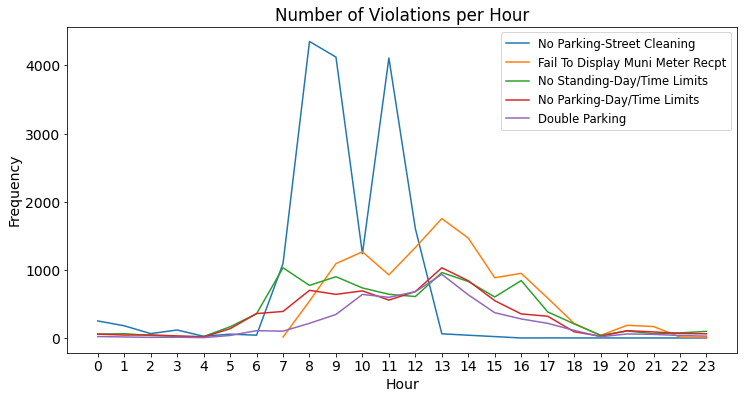

In [300]:
code_desc = {21:'No Parking-Street Cleaning',
             38:'Fail To Display Muni Meter Recpt',
             14:'No Standing-Day/Time Limits',
             20:'No Parking-Day/Time Limits',
             46:'Double Parking'
            }
time_grp = park_addr.groupby(['violation_hour','Violation Code','Violation Desc'])[['Summons Number']].count().reset_index()
fig, ax = plt.subplots(figsize=(12,6))
for c, d in code_desc.items():
    mask = time_grp['Violation Code'] == c
    ax.plot(time_grp[mask]['violation_hour'], time_grp[mask]['Summons Number'], label=d)
ax.set_title('Number of Violations per Hour')
ax.set_xticks(np.arange(np.min(park_addr['violation_hour']), np.max(park_addr['violation_hour'])+1))
ax.set_xlabel('Hour')
ax.set_ylabel('Frequency')
plt.legend()
plt.savefig('../images/v_per_hour.png');

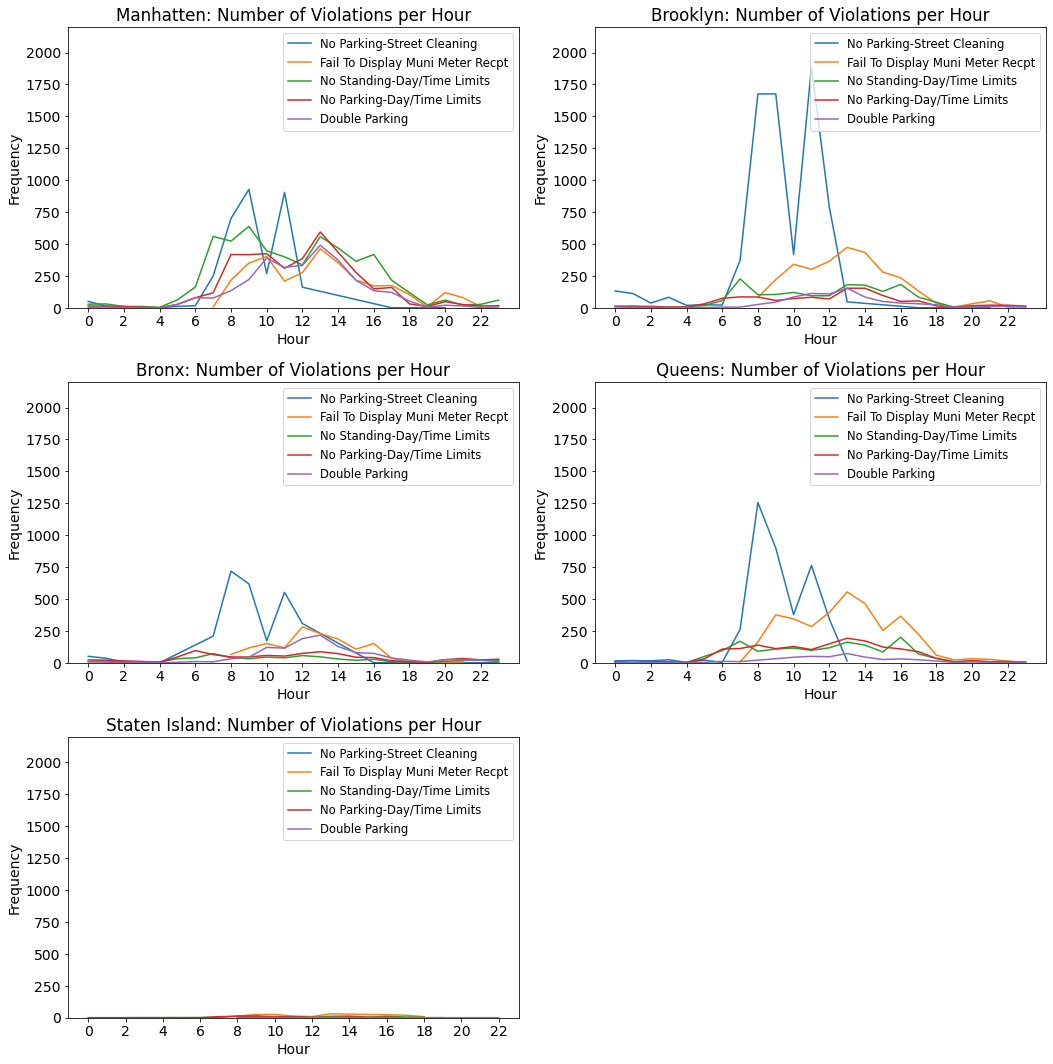

In [308]:
code_desc = {21:'No Parking-Street Cleaning',
             38:'Fail To Display Muni Meter Recpt',
             14:'No Standing-Day/Time Limits',
             20:'No Parking-Day/Time Limits',
             46:'Double Parking'
            }

counties = {'NY':'Manhatten',
            'K':'Brooklyn',
            'BX':'Bronx',
            'Q':'Queens',
            'R': 'Staten Island'
           }
time_grp = park_addr.groupby(['violation_hour','Violation County','Violation Code','Violation Desc'])[['Summons Number']].count().reset_index()
fig, axs = plt.subplots(3,2,figsize=(15,15))

for (county, name), ax in zip(counties.items(), axs.flatten()):
    for c, d in code_desc.items():
        mask = (time_grp['Violation Code'] == c) & (time_grp['Violation County'] == county)
        ax.plot(time_grp[mask]['violation_hour'], time_grp[mask]['Summons Number'], label=d)
        ax.set_xticks(np.arange(np.min(park_addr['violation_hour']), np.max(park_addr['violation_hour'])+1,2))
        ax.legend()
        ax.set_ylim(0,2200)
        ax.set_title(f'{name}: Number of Violations per Hour')
        ax.set_xlabel('Hour')
        ax.set_ylabel('Frequency')
plt.tight_layout()
axs[2][1].remove()
plt.savefig('../images/v_per_hour_and_burough.png');

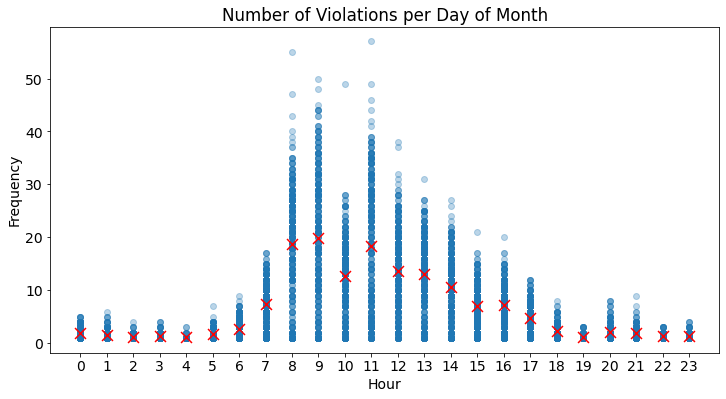

In [329]:
time_grp = park_addr.groupby(['violation_hour','new_date'])[['Summons Number']].count().reset_index()
fig, ax = plt.subplots(figsize=(12,6))

mean = time_grp.groupby(['violation_hour'])[['Summons Number']].mean().reset_index()
ax.scatter(time_grp['violation_hour'], time_grp['Summons Number'], alpha=0.3)
ax.scatter(mean['violation_hour'], mean['Summons Number'], s=120, c='r', marker='x', label='Mean')
ax.set_title('Number of Violations per Day of Month')
ax.set_xticks(np.arange(np.min(time_grp['violation_hour']), np.max(time_grp['violation_hour'])+1))
ax.set_xlabel('Hour')
ax.set_ylabel('Frequency')
plt.savefig('../images/v_per_hour_scatter.png');

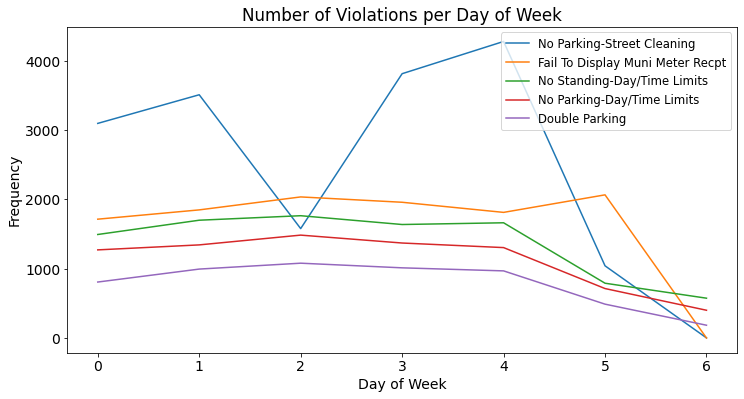

In [309]:
code_desc = {21:'No Parking-Street Cleaning',
             38:'Fail To Display Muni Meter Recpt',
             14:'No Standing-Day/Time Limits',
             20:'No Parking-Day/Time Limits',
             46:'Double Parking'
            }
time_grp = park_addr.groupby(['day_of_week','Violation Code'])[['Summons Number']].count().reset_index()
fig, ax = plt.subplots(figsize=(12,6))
for c, d in code_desc.items():
    mask = time_grp['Violation Code'] == c
    ax.plot(time_grp[mask]['day_of_week'], time_grp[mask]['Summons Number'], label=d)
ax.set_title('Number of Violations per Day of Week')
ax.set_xticks(np.arange(np.min(time_grp['day_of_week']), np.max(time_grp['day_of_week'])+1))
ax.set_xlabel('Day of Week')
ax.set_ylabel('Frequency')
plt.legend()
plt.savefig('../images/v_per_weekday.png');

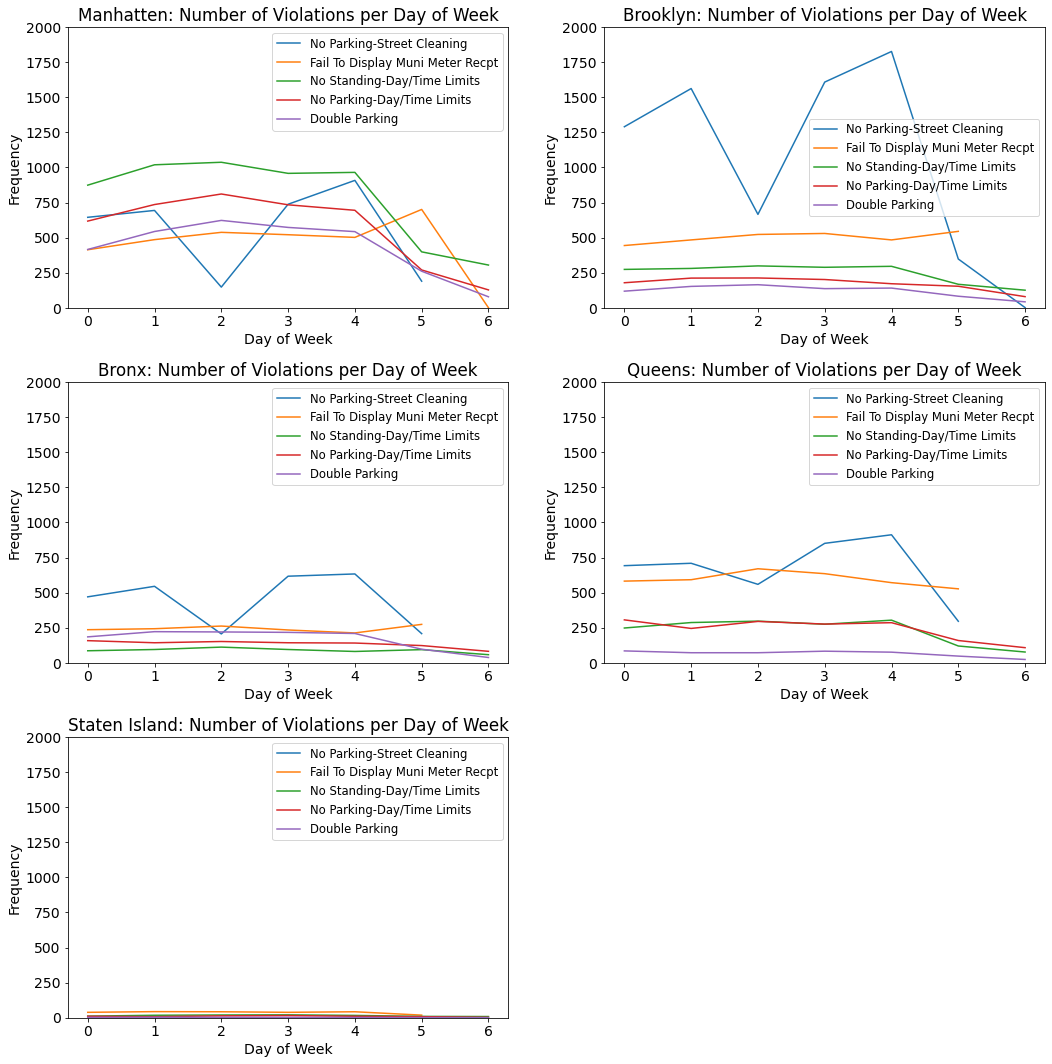

In [310]:
code_desc = {21:'No Parking-Street Cleaning',
             38:'Fail To Display Muni Meter Recpt',
             14:'No Standing-Day/Time Limits',
             20:'No Parking-Day/Time Limits',
             46:'Double Parking'
            }

counties = {'NY':'Manhatten',
            'K':'Brooklyn',
            'BX':'Bronx',
            'Q':'Queens',
            'R': 'Staten Island'
           }
time_grp = park_addr.groupby(['day_of_week','Violation County','Violation Code','Violation Desc'])[['Summons Number']].count().reset_index()
fig, axs = plt.subplots(3,2,figsize=(15,15))

for (county, name), ax in zip(counties.items(), axs.flatten()):
    for c, d in code_desc.items():
        mask = (time_grp['Violation Code'] == c) & (time_grp['Violation County'] == county)
        ax.plot(time_grp[mask]['day_of_week'], time_grp[mask]['Summons Number'], label=d)
        ax.set_xticks(np.arange(np.min(park_addr['day_of_week']), np.max(park_addr['day_of_week'])+1))
        ax.legend()
        ax.set_ylim(0,2000)
        ax.set_title(f'{name}: Number of Violations per Day of Week')
        ax.set_xlabel('Day of Week')
        ax.set_ylabel('Frequency')
plt.tight_layout()
axs[2][1].remove()
plt.savefig('../images/v_per_weekday_and_burough.png');

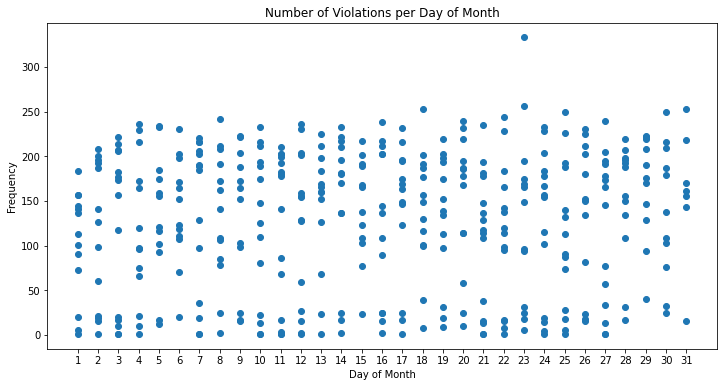

In [216]:
time_grp = park_addr.groupby(['day','new_date'])[['Summons Number']].count().reset_index()
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(time_grp['day'], time_grp['Summons Number'])
ax.set_title('Number of Violations per Day of Month')
ax.set_xticks(np.arange(np.min(time_grp['day']), np.max(time_grp['day'])+1))
ax.set_xlabel('Day of Month')
ax.set_ylabel('Frequency')
plt.savefig('../images/v_per_monthday.png');

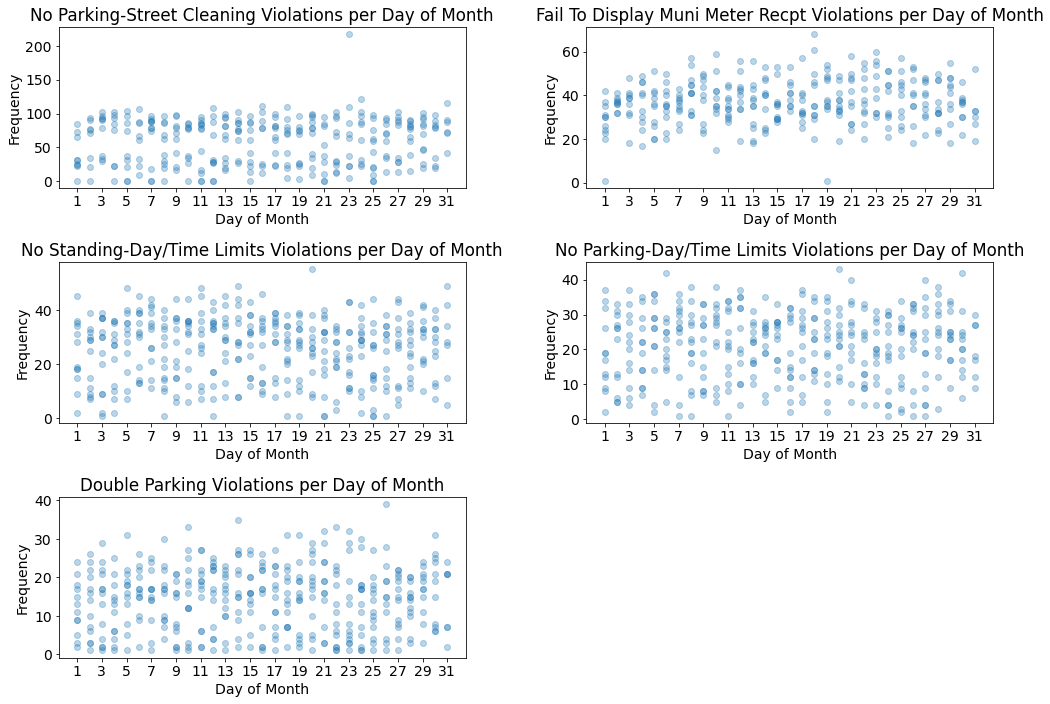

In [320]:
code_desc = {
             21:'No Parking-Street Cleaning',
             38:'Fail To Display Muni Meter Recpt',
             14:'No Standing-Day/Time Limits',
             20:'No Parking-Day/Time Limits',
             46:'Double Parking'
            }
time_grp = park_addr.groupby(['day','new_date','Violation Code','Violation Desc'])[['Summons Number']].count().reset_index()
fig, axs = plt.subplots(3, 2, figsize=(15,10))
for (c, d), ax in zip(code_desc.items(),axs.flatten()):
    mask = time_grp['Violation Code'] == c
    ax.scatter(time_grp[mask]['day'], time_grp[mask]['Summons Number'], alpha=0.3)
    ax.set_title(f'{d} Violations per Day of Month')
    ax.set_xticks(np.arange(np.min(park_addr['day']), np.max(park_addr['day'])+1,2))
    ax.set_xlabel('Day of Month')
    ax.set_ylabel('Frequency')
#     ax.set_ylim(0,240)
plt.tight_layout()
axs[2][1].remove();

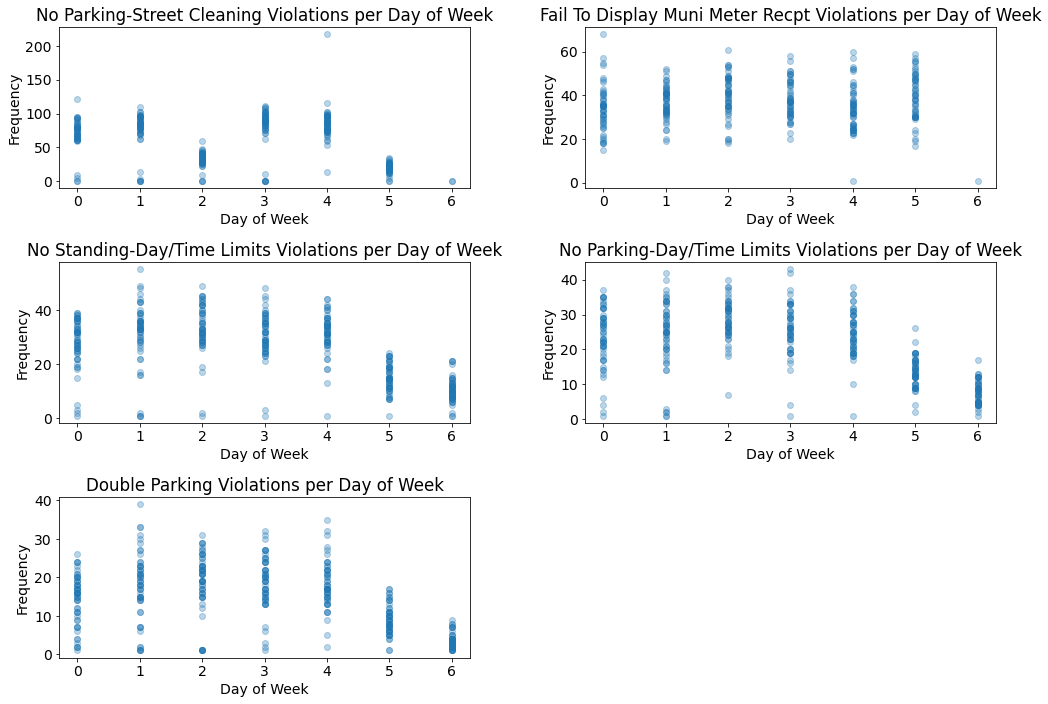

In [319]:
code_desc = {
             21:'No Parking-Street Cleaning',
             38:'Fail To Display Muni Meter Recpt',
             14:'No Standing-Day/Time Limits',
             20:'No Parking-Day/Time Limits',
             46:'Double Parking'
            }
time_grp = park_addr.groupby(['day_of_week','new_date','Violation Code'])[['Summons Number']].count().reset_index()
fig, axs = plt.subplots(3, 2, figsize=(15,10))
for (c, d), ax in zip(code_desc.items(),axs.flatten()):
    mask = time_grp['Violation Code'] == c
    ax.scatter(time_grp[mask]['day_of_week'], time_grp[mask]['Summons Number'], alpha=0.3)
    ax.set_title(f'{d} Violations per Day of Week')
    ax.set_xticks(np.arange(np.min(time_grp['day_of_week']), np.max(time_grp['day_of_week'])+1))
#     ax.set_xticks(['Mon', 'Tue', 'Wed', 'Thurs', 'Fri'])
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Frequency')
plt.tight_layout()
axs[2][1].remove();

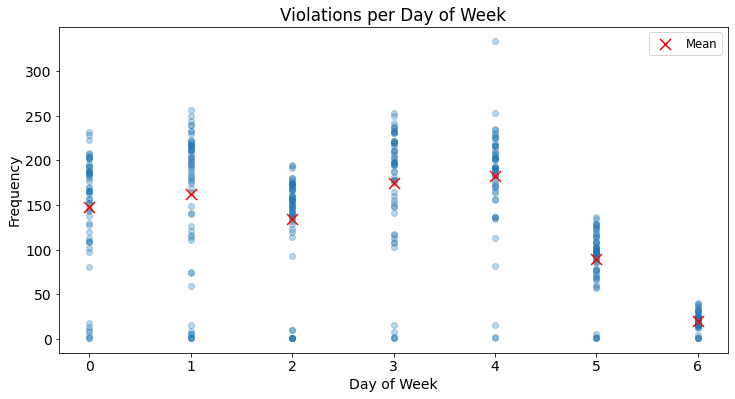

In [321]:
time_grp = park_addr.groupby(['day_of_week','new_date'])[['Summons Number']].count().reset_index()
fig, ax = plt.subplots(figsize=(12,6))
mean = time_grp.groupby(['day_of_week'])[['Summons Number']].mean().reset_index()
ax.scatter(time_grp['day_of_week'], time_grp['Summons Number'], alpha=0.3)
ax.scatter(mean['day_of_week'], mean['Summons Number'], s=120, c='r', marker='x', label='Mean')
ax.set_title('Violations per Day of Week')
ax.set_xticks(np.arange(np.min(time_grp['day_of_week']), np.max(time_grp['day_of_week'])+1))
ax.set_xlabel('Day of Week')
ax.set_ylabel('Frequency')
plt.legend()
plt.savefig('../images/v_per_weekday_scat.png');

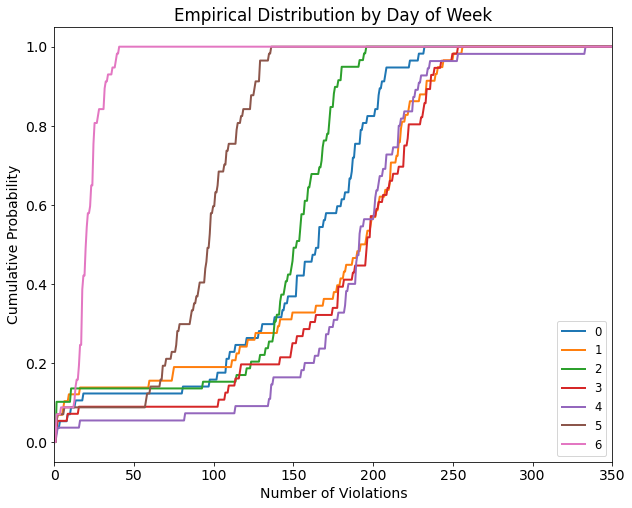

In [322]:
time_grp = park_addr.groupby(['day_of_week','new_date'])[['Summons Number']].count().reset_index()
x = np.linspace(0, 350, num=500)

fig, ax = plt.subplots(figsize=(10, 8))
for day in set(time_grp['day_of_week']):
    mask = time_grp['day_of_week'] == day
    ax.plot(x, empirical_distribution(x, time_grp[mask]['Summons Number']), linewidth=2, label=day)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(0, 350)
ax.set_ylabel('Cumulative Probability')
ax.set_xlabel('Number of Violations')
plt.legend()
# ax[0].tick_params(axis='both', which='major', labelsize=15)
# one_dim_scatterplot(data, ax[1], s=25)
ax.set_title("Empirical Distribution by Day of Week")
plt.savefig('../images/empir_dist.png');

In [326]:
grp_count_p_values(time_grp, 'day_of_week')

Group A   Group A Mean      Group B   Group B Mean  Mean Difference  \
19 4.0000000000 182.3454545455 6.0000000000  20.4210526316   161.9244019139   
18 4.0000000000 182.3454545455 5.0000000000  89.5087719298    92.8366826156   
20 5.0000000000  89.5087719298 6.0000000000  20.4210526316    69.0877192982   
17 3.0000000000 174.9107142857 6.0000000000  20.4210526316   154.4896616541   
5  0.0000000000 147.1228070175 6.0000000000  20.4210526316   126.7017543860   
16 3.0000000000 174.9107142857 5.0000000000  89.5087719298    85.4019423559   
10 1.0000000000 162.0344827586 6.0000000000  20.4210526316   141.6134301270   
14 2.0000000000 134.6610169492 6.0000000000  20.4210526316   114.2399643176   
13 2.0000000000 134.6610169492 5.0000000000  89.5087719298    45.1522450193   
4  0.0000000000 147.1228070175 5.0000000000  89.5087719298    57.6140350877   
9  1.0000000000 162.0344827586 5.0000000000  89.5087719298    72.5257108288   
12 2.0000000000 134.6610169492 4.0000000000 182.3454545455    47.6844375963   
11 2.0000000000 134.6610169492 3.0000000000 174.9107142857    40.2496973366   
6  1.0000000000 162.0344827586 2.0000000000 134.6610169492    27.3734658095   
3  0.0000000000 147.1228070175 4.0000000000 182.3454545455    35.2226475279   
2  0.0000000000 147.1228070175 3.0000000000 174.9107142857    27.7879072682   
0  0.0000000000 147.1228070175 1.0000000000 162.0344827586    14.9116757411   
1  0.0000000000 147.1228070175 2.0000000000 134.6610169492    12.4617900684   
7  1.0000000000 162.0344827586 3.0000000000 174.9107142857    12.8762315271   
8  1.0000000000 162.0344827586 4.0000000000 182.3454545455    20.3109717868   
15 3.0000000000 174.9107142857 4.0000000000 182.3454545455     7.4347402597   

        P-Value  
19 0.0000000000  
18 0.0000000000  
20 0.0000000000  
17 0.0000000000  
5  0.0000000000  
16 0.0000000000  
10 0.0000000000  
14 0.0000000000  
13 0.0000000001  
4  0.0000000007  
9  0.0000000076  
12 0.0000000105  
11 0.0000019608  
6  0.0001222326  
3  0.0003634068  
2  0.0018526474  
0  0.0193616584  
1  0.0420687122  
7  0.5217868449  
8  0.6171967369  
15 0.8734567409

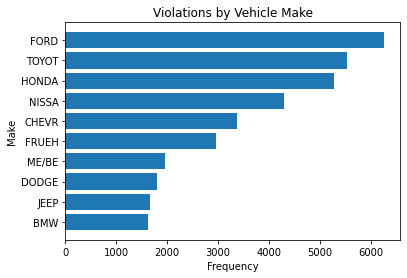

In [123]:
makes = park_addr['Vehicle Make'].value_counts()[:10]

fig, ax = plt.subplots()

ax.barh(makes.index, makes)
ax.set_title('Violations by Vehicle Make')
ax.set_xlabel('Frequency')
ax.set_ylabel('Make')
plt.gca().invert_yaxis();

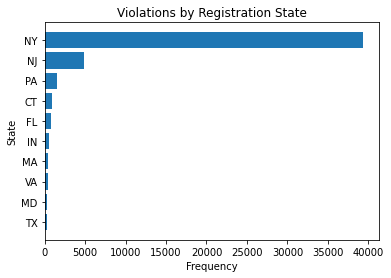

In [95]:
reg_state = park_addr['Registration State'].value_counts()[:10]

fig, ax = plt.subplots()

ax.barh(reg_state.index, reg_state)
ax.set_title('Violations by Registration State')
ax.set_xlabel('Frequency')
ax.set_ylabel('State')
plt.gca().invert_yaxis();

In [85]:
m = folium.Map(location=[40.7128, -74.0060])

m.add_child(FastMarkerCluster(park_addr[['lat', 'long']].values.tolist()))

m

In [256]:
m = folium.Map(location=[40.7128, -74.0060])

m.add_child(FastMarkerCluster(violation21[['lat', 'long']].values.tolist(), name='No Parking-Street Cleaning'))
m.add_child(FastMarkerCluster(violation38[['lat', 'long']].values.tolist(), name='Fail To Display Muni Meter Recpt'))
m.add_child(FastMarkerCluster(violation14[['lat', 'long']].values.tolist(), name='No Standing-Day/Time Limits'))
m.add_child(FastMarkerCluster(violation20[['lat', 'long']].values.tolist(), name='No Parking-Day/Time Limits'))
m.add_child(FastMarkerCluster(violation46[['lat', 'long']].values.tolist(), name='Double Parking'))
folium.LayerControl(collapsed=False).add_to(m)          
m.save('../images/parking_map_w_layers.html')
m

In [258]:
m = folium.Map(location=[40.7128, -74.0060])

m.add_child(FastMarkerCluster(mon[['lat', 'long']].values.tolist(), name='Monday'))
m.add_child(FastMarkerCluster(tues[['lat', 'long']].values.tolist(), name='Tuesday'))
m.add_child(FastMarkerCluster(wed[['lat', 'long']].values.tolist(), name='Wednesday'))
m.add_child(FastMarkerCluster(thurs[['lat', 'long']].values.tolist(), name='Thursday'))
m.add_child(FastMarkerCluster(fri[['lat', 'long']].values.tolist(), name='Friday'))
m.add_child(FastMarkerCluster(sat[['lat', 'long']].values.tolist(), name='Saturday'))
m.add_child(FastMarkerCluster(sun[['lat', 'long']].values.tolist(), name='Sunday'))
folium.LayerControl(collapsed=False).add_to(m)          
# m.save('../docs/parking_map_w_layers.html')
m

In [305]:
violation_hour = pd.pivot_table(park_addr,values='Summons Number', 
                                index=['Violation County'], 
                                columns=['Violation Desc'], 
                                aggfunc='count', 
                                fill_value=0)


In [306]:
violation_hour

Violation Desc    Double Parking  Fail To Display Muni Meter Recpt  \
Violation County                                                     
BX                          1188                              1462   
K                            841                              3010   
NY                          3039                              3163   
Q                            460                              3577   
R                             11                               227   

Violation Desc    No Parking-Day/Time Limits  No Parking-Street Cleaning  \
Violation County                                                           
BX                                       942                        2679   
K                                       1212                        7302   
NY                                      3992                        3323   
Q                                       1675                        4019   
R                                         71                           0   

Violation Desc    No Standing-Day/Time Limits  
Violation County                               
BX                                        621  
K                                        1733  
NY                                       5557  
Q                                        1608  
R                                         107

In [126]:
park_addr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51819 entries, 0 to 51818
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Summons Number           51819 non-null  int64         
 1   Plate ID                 51818 non-null  object        
 2   Registration State       51819 non-null  object        
 3   Plate Type               51819 non-null  object        
 4   Issue Date               51819 non-null  object        
 5   Violation Code           51819 non-null  int64         
 6   Vehicle Body Type        51819 non-null  object        
 7   Vehicle Make             51819 non-null  object        
 8   Issuing Agency           51819 non-null  object        
 9   Street Code1             51819 non-null  int64         
 10  Street Code2             51819 non-null  int64         
 11  Street Code3             51819 non-null  int64         
 12  Vehicle Expiration Date  51819 n